In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# 定义一个 Transformer Encoder 模块
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 多头自注意力层
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = tf.keras.layers.Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # 前馈网络层
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = tf.keras.layers.Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# 构建基于 Transformer 的表格数据模型
def build_transformer_tabular(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    # 将输入的 (num_features,) 重新reshape为 (num_features, 1)，每个特征作为一个 token
    x = Reshape((input_shape[0], 1))(inputs)
    # 将每个 token 投影到 head_size 维度
    x = Dense(head_size)(x)
    
    # 添加多个 Transformer Encoder 模块
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # 对序列进行全局平均池化
    x = GlobalAveragePooling1D()(x)
    
    # 添加 MLP 作为分类头
    for units in mlp_units:
        x = Dense(units, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    
    # 输出层，多分类任务 
    outputs = Dense(4, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    return model

# 设置模型参数
input_shape = (9,)  
head_size = 64       
num_heads = 4        
ff_dim = 64          
num_transformer_blocks = 2  
mlp_units = [64]     
dropout = 0.1        
mlp_dropout = 0.1    

# 构建模型
model = build_transformer_tabular(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 9, 1)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 9, 64)          │            128 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 9, 64)          │         66,368 │ dense[0][0],           │
│ (MultiHeadAttention)      │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 9, 64)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 9, 64)          │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 9, 64)          │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 9, 64)          │          4,160 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 9, 64)          │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 9, 64)          │          4,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 9, 64)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 9, 64)          │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 9, 64)          │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 9, 64)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 9, 64)          │              0 │ dropout_4[0][0],       │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 9, 64)          │            128 │ add_2[0][0]            │
│ (LayerNormalization) 

 Total params: 154,436 (603.27 KB)

 Trainable params: 154,436 (603.27 KB)

 Non-trainable params: 0 (0.00 B)

In [2]:
X_normalized = pd.read_csv('/kaggle/input/qiche/X_normalized.csv')
X_test_normalized = pd.read_csv('/kaggle/input/qiche/X_test_normalized.csv')
y_train = pd.read_csv('/kaggle/input/qiche/y_train.csv')
y_test = pd.read_csv('/kaggle/input/qiche/y_test.csv')

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. 训练模型
history = model.fit(
    X_normalized,            # 训练特征
    y_train,                 # 训练标签
    epochs=20,               
    batch_size=512,          
    validation_data=(X_test_normalized, y_test),
    verbose=1
)

Epoch 1/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.9645 - loss: 0.1464 - val_accuracy: 0.9674 - val_loss: 0.1129
Epoch 2/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9667 - loss: 0.1178 - val_accuracy: 0.9676 - val_loss: 0.1103
Epoch 3/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9673 - loss: 0.1097 - val_accuracy: 0.9677 - val_loss: 0.1074
Epoch 4/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9673 - loss: 0.1054 - val_accuracy: 0.9681 - val_loss: 0.0977
Epoch 5/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9680 - loss: 0.1006 - val_accuracy: 0.9691 - val_loss: 0.0915
Epoch 6/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9684 - loss: 0.0966 - val_accuracy: 0.9700 - val_loss: 0.0904
Epoch 7/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9691 - loss: 0.0931 - val_accuracy: 0.9708 - val_loss: 0.0852
Epoch 8/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9698 - loss: 

In [5]:
# 2. 评估模型在测试集上的表现
test_loss, test_acc = model.evaluate(X_test_normalized, y_test, verbose=0)
print("测试集损失: {:.4f}".format(test_loss))
print("测试集准确率: {:.4f}".format(test_acc))

测试集损失: 0.0552
测试集准确率: 0.9793


In [6]:
# 3. 生成预测结果
y_pred_probs = model.predict(X_test_normalized)  # 输出为各类别的概率
y_pred = np.argmax(y_pred_probs, axis=1)           # 转换为预测的类别标签

# 4. 输出分类报告和混淆矩阵
print("\n分类报告:")
print(classification_report(y_test, y_pred, digits=4))

print("混淆矩阵:")
print(confusion_matrix(y_test, y_pred))

7289/7289 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step

分类报告:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9835    0.9953    0.9894    225453
           1     0.0000    0.0000    0.0000         1
           2     0.7901    0.5193    0.6267      7741
           3     0.0000    0.0000    0.0000        39

    accuracy                         0.9793    233234
   macro avg     0.4434    0.3786    0.4040    233234
weighted avg     0.9769    0.9793    0.9771    233234

混淆矩阵:
[[224385      0   1068      0]
 [     1      0      0      0]
 [  3721      0   4020      0]
 [    39      0      0      0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


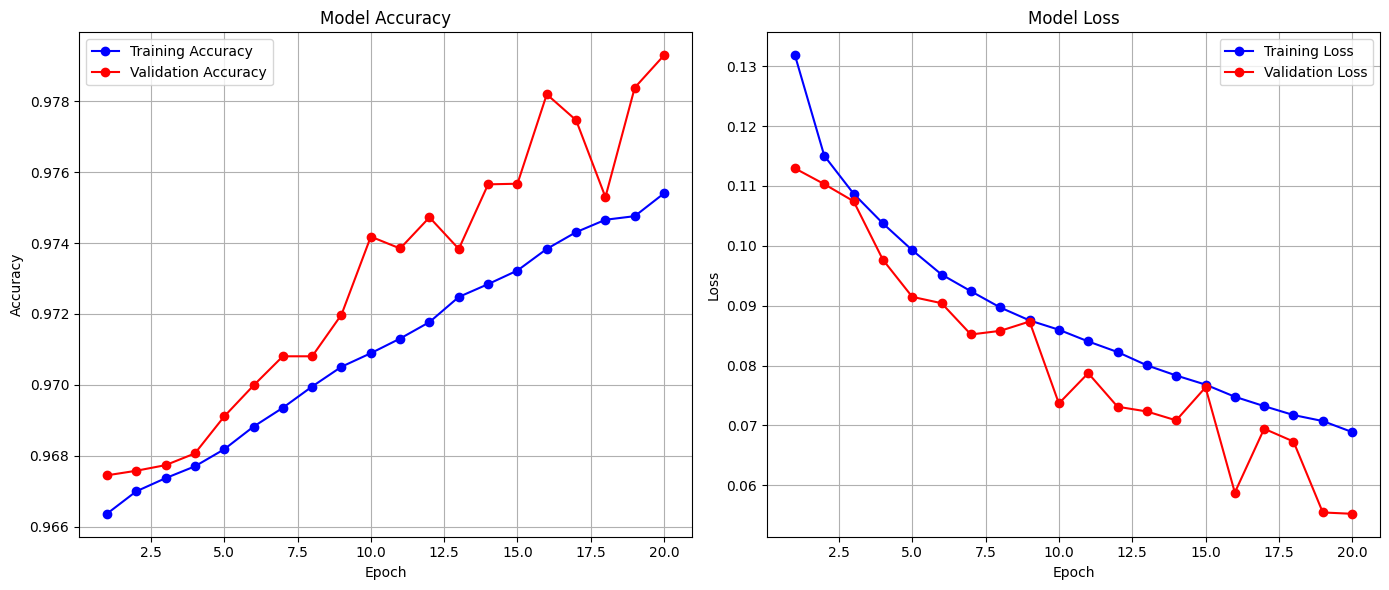

In [20]:
# 5. 可视化训练过程
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation accuracy
axes[0].plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
axes[0].plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation loss
axes[1].plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
axes[1].plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [21]:
model.save('my_trained_model.h5')

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_normalized, y_train.values.ravel())
y_pred_rf = rf_model.predict(X_test_normalized)
print("\n随机森林模型报告:")
print(classification_report(y_test, y_pred_rf))
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred_rf))
print("准确率: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))


随机森林模型报告:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225453
           1       0.00      0.00      0.00         1
           2       0.97      0.96      0.97      7741
           3       0.79      0.38      0.52        39

    accuracy                           1.00    233234
   macro avg       0.69      0.59      0.62    233234
weighted avg       1.00      1.00      1.00    233234

混淆矩阵:
 [[225216      0    233      4]
 [     1      0      0      0]
 [   292      0   7449      0]
 [    24      0      0     15]]
准确率: 0.9976


In [6]:
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_normalized, y_train.values.ravel())
y_pred_xgb = xgb_model.predict(X_test_normalized)
print("\nXGBoost 模型报告:")
print(classification_report(y_test, y_pred_xgb))
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred_xgb))
print("准确率: {:.4f}".format(accuracy_score(y_test, y_pred_xgb)))


XGBoost 模型报告:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225453
           1       0.00      0.00      0.00         1
           2       0.91      0.89      0.90      7741
           3       0.77      0.44      0.56        39

    accuracy                           0.99    233234
   macro avg       0.67      0.58      0.61    233234
weighted avg       0.99      0.99      0.99    233234

混淆矩阵:
 [[224784      0    664      5]
 [     1      0      0      0]
 [   836      0   6905      0]
 [    22      0      0     17]]
准确率: 0.9934


基于注意力预处理的随机森林混合模型

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ----------------------------
# 1. 构建带注意力加权模块的神经网络
# ----------------------------
def build_attention_classifier(input_dim, hidden_units=32, num_classes=4):
    """
    构建一个简单的注意力加权网络：
      - 通过 Dense+softmax 获得与输入相同维度的注意力权重
      - 将输入与注意力权重逐元素相乘，并加入残差连接，得到新的特征表示
      - 通过一个隐藏层（命名为 'features'）输出新的特征
      - 最后接 softmax 层输出分类概率
    """
    inputs = Input(shape=(input_dim,))
    attn_weights = Dense(input_dim, activation='softmax', name='attn_weights')(inputs)
    # 对输入进行加权
    weighted_inputs = Multiply()([inputs, attn_weights])
    # 将加权结果与原始输入相加
    new_representation = Add()([weighted_inputs, inputs])
    # 生成新的特征表示
    features = Dense(hidden_units, activation='relu', name='features')(new_representation)
    # 分类输出
    outputs = Dense(num_classes, activation='softmax')(features)
    
    model = Model(inputs, outputs)
    return model

input_dim = X_normalized.shape[1]   
num_classes = len(np.unique(y_train))  

# 构建注意力模型
attn_model = build_attention_classifier(input_dim, hidden_units=32, num_classes=num_classes)
attn_model.compile(optimizer=Adam(learning_rate=0.001), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])
attn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attn_weights (Dense)      │ (None, 9)              │             90 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 9)              │              0 │ input_layer[0][0],     │
│                           │                        │                │ attn_weights[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 9)              │              0 │ multiply[0][0],        │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ features (Dense)          │ (None, 32)             │            320 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            132 │ features[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 542 (2.12 KB)

 Trainable params: 542 (2.12 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 2. 训练注意力模型
# ----------------------------
history_attn = attn_model.fit(
    X_normalized, 
    y_train, 
    epochs=10, 
    batch_size=128, 
    validation_data=(X_test_normalized, y_test),
    verbose=1
)

Epoch 1/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9486 - loss: 0.1927 - val_accuracy: 0.9666 - val_loss: 0.1079
Epoch 2/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9667 - loss: 0.1049 - val_accuracy: 0.9668 - val_loss: 0.0988
Epoch 3/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9673 - loss: 0.0971 - val_accuracy: 0.9676 - val_loss: 0.0930
Epoch 4/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9678 - loss: 0.0923 - val_accuracy: 0.9682 - val_loss: 0.0901
Epoch 5/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9679 - loss: 0.0898 - val_accuracy: 0.9680 - val_loss: 0.0873
Epoch 6/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9682 - loss: 0.0871 - val_accuracy: 0.9677 - val_loss: 0.0859
Epoch 7/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9682 - loss: 0.0858 - val_accuracy: 0.9678 - val_loss: 0.0853
Epoch 8/10
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9687 - loss: 0

In [5]:
# 3. 提取注意力模块生成的特征表示
# ----------------------------
feature_extractor = Model(attn_model.input, attn_model.get_layer('features').output)
X_train_attn = feature_extractor.predict(X_normalized)
X_test_attn = feature_extractor.predict(X_test_normalized)

29155/29155 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
7289/7289 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [7]:
!pip install tqdm_joblib

In [9]:
# 4. 使用随机森林模型对新的特征表示进行训练和评估
rf_attn = RandomForestClassifier(n_estimators=100, random_state=42)
rf_attn.fit(X_train_attn, y_train.values.ravel())
y_pred_rf_attn = rf_attn.predict(X_test_attn)

print("Random Forest on Attention Features:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_rf_attn)))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_attn, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_attn))

Random Forest on Attention Features:
Accuracy: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225453
           1       0.00      0.00      0.00         1
           2       0.98      0.93      0.95      7741
           3       0.84      0.41      0.55        39

    accuracy                           1.00    233234
   macro avg       0.71      0.58      0.63    233234
weighted avg       1.00      1.00      1.00    233234

Confusion Matrix:
[[225331      0    119      3]
 [     1      0      0      0]
 [   580      0   7161      0]
 [    23      0      0     16]]


In [11]:
new_data_normalized = pd.read_csv('/kaggle/input/qiche/X_pred_normalized.csv')
# 通过注意力模型提取新的特征表示
new_features = feature_extractor.predict(new_data_normalized)
# 利用训练好的随机森林模型进行预测
new_predictions = rf_attn.predict(new_features)
print("新数据预测结果：", new_predictions)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
新数据预测结果： [0 0 0 ... 0 0 0]


In [14]:
predictions_df = pd.DataFrame(new_predictions, columns=['Predicted_Label'])
predictions_df.to_csv("/kaggle/working/predictions.csv", index=False)